In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


def zscore(series):
    return (series - series.mean()) / series.std()


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def sigmoid(x, k=1, x0=0):
    return 1 / (1 + np.exp(-k * (x - x0)))


def adjusted_sigmoid(x, f_min=0.01, f_max=0.1, k=1, x0=0):
    return f_min + (f_max - f_min) * sigmoid(x, k=k, x0=x0)


def global_sigmoid(x, f_min, f_max, k=1, x0=0):
    if x > 0:
        return adjusted_sigmoid(x, f_min, f_max, k, x0)
    else:
        return adjusted_sigmoid(-x, f_min, f_max, k, x0)
    
    
def calculate_markout(d, v, f, p):
    m = d * v * (f - p)
    return m


data_p1 = pd.read_pickle('data/Merged_CEX_DEX_v2_p1.pkl')
data_p2 = pd.read_pickle('data/Merged_CEX_DEX_v2_p2.pkl')
data_p3 = pd.read_pickle('data/Merged_CEX_DEX_v2_p3.pkl')

data_p1['time'] = pd.to_datetime(data_p1['time'])
data_p2['time'] = pd.to_datetime(data_p2['time'])
data_p3['time'] = pd.to_datetime(data_p3['time'])

data = pd.concat([data_p1, data_p2, data_p3])
data = data.sort_values('time')

In [11]:
data['impermanent_loss'] = (2 * np.sqrt(data['price_dex'].shift(1) / data['price_dex']) / (1 + data['price_dex'].shift(1) / data['price_dex']) - 1).fillna(0)
data['LVR_nbtoken']= data['LVR']/data['price_dex']
data['avg_gas']    = data['gasUsed'] * data['gasPrice_eth'].rolling(100).mean() * data['price_dex']
data['arb_fee']    = (np.abs(data['LVR_clean'] * data['amountUSD']) - (data['tcost_usd'] - data['avg_gas']))*100 / data['amountUSD']
data['LVR_zscore'] = zscore(data['LVR'])
data['std']             = data['price_dex'].rolling(100).std()
data['mean_rol_amount'] = data['amountUSD'].rolling(10).mean()
data['rol_amountUSD']   = data['amountUSD'].rolling(100).sum()

# can be seen as looking ahead but in a DEX we can compute it aheat with the liquidity and the amount
data['price_impact']    = data['price_dex'].pct_change(1).shift(-1)*100

data['time_diff']           = data['time'].diff().dt.total_seconds().fillna(0)
data['rolling_time_span']   = data['time_diff'].rolling(window=3600, min_periods=1).sum()
data['rolling_trade_count'] = data['time'].rolling(window=3600, min_periods=1).count()
data['lambda'] = data['rolling_trade_count'] / data['rolling_time_span']
data['lambda'].replace([float('inf'), float('-inf'), pd.NA], 0, inplace=True)
data = data.drop(columns=['time_diff'])

data['target_fee'] = -np.tanh(np.sign(data['amount1']) * data['arb_fee']/100)

data = data.dropna()

features = ['LVR_nbtoken', 'LVR', 'std', 'mean_rol_amount', 'avg_gas', 'price_impact', 'rol_amountUSD', 'lambda',  'rolling_time_span', 'amountUSD']
target = 'tcost_usd'

lower_bound = data[features].quantile(0.10)
upper_bound = data[features].quantile(0.90)
filtered_indices = data[features].apply(lambda x: x.between(lower_bound[x.name], upper_bound[x.name])).all(axis=1)
data_filtered = data.loc[filtered_indices].copy()

f_min = 0.01
f_max = 0.1
w     = 0.04
k     = 1.75  # Steepness of the curve

params = {}
for f in features:
    params[f] = {'f_min': f_min, 'f_max': f_max, 'k': k, 'x0': (f_max-f_min)/(2*w)}
    
    
data

,amount0,amount1,amountUSD,origin,sender,recipient,timestamp,gasUsed,gasPrice_wei,gasPrice_eth,...,arb_fee,LVR_zscore,std,mean_rol_amount,rol_amountUSD,price_impact,rolling_time_span,rolling_trade_count,lambda,target_fee
99,6318.571324,-2.753365,6310.474821,0xf3e01e963796ad8ed86fc7dbce195eaa3aaf4e4a,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704069e+09,414642,1.216669e+10,1.216669e-08,...,57.565562,-0.015658,4.766625,31679.388299,3.274054e+06,-0.009999,1404.0,100.0,0.071225,0.519501
100,-160.477545,0.070000,160.352835,0xea08db5fb88d6f1f4978400ec2c57d9a29e85e99,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0xef5edb29b4eb20501de89718daa7d1ad108efb66,1.704069e+09,445316,1.225569e+10,1.225569e-08,...,87.929747,-0.013781,4.713025,31196.151489,3.256138e+06,0.000000,1404.0,101.0,0.071937,-0.706067
101,-99.931075,0.043590,99.853435,0x5e969b786482489323c94b8abc4eb03a41da527a,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0x5e969b786482489323c94b8abc4eb03a41da527a,1.704069e+09,270277,1.144304e+10,1.144304e-08,...,18.581544,-0.013851,4.655251,31203.846347,3.255538e+06,0.010000,1428.0,102.0,0.071429,-0.183706
102,1500.000000,-0.653642,1498.084492,0xfcb40a45a51a31f568ef39e0f6dfe5f3b21711df,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704069e+09,303561,1.095438e+10,1.095438e-08,...,75.997578,-0.014411,4.599576,20749.062023,3.232065e+06,0.000000,1476.0,103.0,0.069783,0.641063
103,-550.210323,0.240000,549.781949,0xcdb343941111e306d71f141689b5b69d07ca6f59,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704069e+09,306333,1.182152e+10,1.182152e-08,...,76.959780,-0.013638,4.539570,20425.349686,3.231848e+06,0.000000,1500.0,104.0,0.069333,-0.646696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187221,-16804.135320,7.369011,16802.205053,0x4066e9bd5618373d2da7a1cb7bba03ef800875ee,0x6719c6ebf80d6499ca9ce170cda72beb3f1d1a54,0x6719c6ebf80d6499ca9ce170cda72beb3f1d1a54,1.706746e+09,217474,8.602831e+10,8.602831e-08,...,5.121515,-0.014293,1.229886,18697.005457,1.080576e+06,0.000000,47268.0,3600.0,0.076161,-0.051170
187222,-2280.293805,1.000000,2280.074254,0x1b0cae4374ebc96289d8dab50eeffc20d3528503,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0x1b0cae4374ebc96289d8dab50eeffc20d3528503,1.706746e+09,284804,3.171776e+10,3.171776e-08,...,5.114578,-0.013906,1.265223,18890.788832,1.082558e+06,0.000000,47244.0,3600.0,0.076200,-0.051101
187223,15000.000000,-6.571360,14990.873565,0xcf99f91f0d834f26b8e7267ee99203bef3648edd,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.706746e+09,280947,2.010458e+10,2.010458e-08,...,0.322773,-0.013822,1.298429,19990.184415,1.018821e+06,0.070021,47256.0,3600.0,0.076181,0.003228
187225,1000.000000,-0.437797,999.056241,0xe86866e5f456d5f986cec61e43bfcec6065b80eb,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.706746e+09,279656,2.268775e+10,2.268775e-08,...,160.210113,-0.013041,1.302969,20063.044481,1.015755e+06,0.000000,47256.0,3600.0,0.076181,0.921984


In [12]:
X_filtered = data_filtered[features]
y_filtered = data_filtered[target]
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)

model = RandomForestRegressor(random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

feature_importances = model.feature_importances_ / model.feature_importances_.sum()
features_importance_normalized = {feature: importance for feature, importance in zip(features, feature_importances)}

buy_subset = data_filtered[data_filtered['amount1'] < 0].copy()
sell_subset = data_filtered[data_filtered['amount1'] > 0].copy()

for f in features:    
    # here for each features the parameters of the sigmoid will be the one to calibrate
    buy_subset[f'{f}_fee'] = buy_subset[f].apply(lambda x: adjusted_sigmoid(x, params[f]['f_min'], params[f]['f_max'], params[f]['k'], params[f]['x0']))
    sell_subset[f'{f}_fee'] = -sell_subset[f].apply(lambda x: adjusted_sigmoid(-x, params[f]['f_min'], params[f]['f_max'], k, params[f]['x0']))

combined_data = pd.concat([buy_subset, sell_subset])

# Apply feature importances as weights
for f in features:
    weight = features_importance_normalized[f]
    combined_data[f'{f}_weighted_fee'] = combined_data[f'{f}_fee'] * weight

# sum weighted fees to get a combined fee
weighted_fee_columns = [f'{f}_weighted_fee' for f in features]
combined_data['combined_fee'] = combined_data[weighted_fee_columns].sum(axis=1)
combined_data['target_fee_usd'] = combined_data['target_fee'] * combined_data['amount0']


In [24]:
metrics = combined_data.resample('1Min', on='time_dex').agg({
    'price_dex'           : 'ohlc',
    'amount0'             : 'sum',
    'amount1'             : 'sum',
    'amountUSD'           : 'sum',
    'LVR'                 : 'sum',
    'impermanent_loss'    : 'sum',
    'tcost_usd'           : 'sum',
    'target_fee_usd'      : 'sum',
    'combined_fee'        : 'sum',
})
metrics.columns = metrics.columns.droplevel(0)
metrics = metrics.rename(columns={'amountUSD': 'volumeUSD'})
metrics['1m_volumeUSD'] = metrics['volumeUSD'].rolling(window=60).sum()

metrics['future_close'] = metrics['close'].shift(-60)
metrics = metrics.dropna()

metrics['markout'] = metrics.apply(lambda x: calculate_markout(d=np.sign(x['amount0']), v=x['volumeUSD'], f=x['future_close'], p=x['close']), axis=1)

pool_fee_rate = 0.05/100

metrics['trade_direction'] = np.sign(metrics['amount0'])
metrics['cfee'] = pool_fee_rate * metrics['volumeUSD']
metrics['dfee'] = metrics['combined_fee'] * metrics['volumeUSD']

metrics['cpnl'] = metrics['close'].shift(-1) - metrics['close'] + metrics['cfee'].abs()
metrics['dpnl'] = metrics['close'].shift(-1) - metrics['close'] + metrics['dfee'].abs()

metrics['cfee_cumul'] = metrics['cfee'].cumsum()
metrics['dfee_cumul'] = metrics['dfee'].cumsum()
metrics['avg_7m_cfee'] = (metrics['volumeUSD'] * pool_fee_rate).rolling(window=7).mean()

metrics['cpnl_5m_positive'] = metrics['cpnl'].rolling(window=5).apply(lambda x: np.sum(x[x>0]))
metrics['cpnl_5m_negative'] = metrics['cpnl'].rolling(window=5).apply(lambda x: np.sum(x[x<0]))
# Calculate a 7 min ma of percent toxic flow:
metrics['c%_toxic_flow_ma_7m'] = (metrics['cpnl_5m_negative'] / (metrics['cpnl_5m_negative'] + metrics['cpnl_5m_positive'])).rolling(window=7).mean()

metrics['dpnl_5m_positive'] = metrics['dpnl'].rolling(window=5).apply(lambda x: np.sum(x[x>0]))
metrics['dpnl_5m_negative'] = metrics['dpnl'].rolling(window=5).apply(lambda x: np.sum(x[x<0]))
# Calculate a 7 min ma of percent toxic flow:
metrics['d%_toxic_flow_ma_7m'] = (metrics['dpnl_5m_negative'] / (metrics['dpnl_5m_negative'] + metrics['dpnl_5m_positive'])).rolling(window=7).mean()

metrics.dropna()

,open,high,low,close,amount0,amount1,volumeUSD,LVR,impermanent_loss,tcost_usd,...,dpnl,cfee_cumul,dfee_cumul,avg_7m_cfee,cpnl_5m_positive,cpnl_5m_negative,c%_toxic_flow_ma_7m,dpnl_5m_positive,dpnl_5m_negative,d%_toxic_flow_ma_7m
time_dex,,,,,,,,,,,,,,,,,,,,,
2024-01-01 13:17:00,2302.879452,2302.879452,2302.879452,2302.879452,-1478.491453,0.642350,1477.744322,0.886795,0.000000e+00,19.161289,...,37.817408,55.792961,9.807953e+03,4.394901,28.510747,0.0,-0.153024,10124.645616,0.0,-0.000406
2024-01-01 13:18:00,2302.879452,2302.879452,2302.879452,2302.879452,14899.513588,-6.464241,27078.392229,-6.189643,0.000000e+00,46.495609,...,932.564155,69.332158,1.074052e+04,5.530495,37.511033,0.0,-0.149423,10684.390316,0.0,-0.000406
2024-01-01 13:19:00,2302.879452,2302.879452,2302.879452,2302.879452,-1071.543167,0.465542,1070.996838,0.619426,0.000000e+00,9.979610,...,15.405829,69.867656,1.072695e+04,5.590555,28.677489,0.0,-0.119764,5850.442159,0.0,-0.000261
2024-01-01 13:21:00,2304.261525,2304.722401,2304.261525,2304.722401,49353.570060,-21.410436,50713.322884,-15.262692,-4.999500e-09,13.946786,...,3020.689823,95.224317,1.374741e+04,8.860278,43.451165,0.0,-0.090464,4022.338922,0.0,-0.000133
2024-01-01 13:22:00,2304.952873,2304.952873,2304.952873,2304.952873,-5278.321730,2.291309,5273.438115,1.122179,0.000000e+00,42.594207,...,202.419158,97.861036,1.354476e+04,7.701000,44.649896,0.0,-0.066799,4208.896373,0.0,-0.000075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-31 22:39:00,2281.106770,2281.563014,2281.106770,2281.563014,7720.145540,-3.375847,32253.267190,-6.714486,-1.249875e-09,86.822303,...,1347.612145,105462.581610,1.786333e+07,17.158311,57.910396,0.0,-0.004639,6256.732370,0.0,0.000000
2024-01-31 22:40:00,2281.563014,2281.563014,2281.563014,2281.563014,-3969.855780,1.740919,3967.606641,0.074947,0.000000e+00,186.341550,...,157.001146,105464.565413,1.786317e+07,12.300530,54.411662,0.0,-0.001224,5876.328221,0.0,0.000000
2024-01-31 22:41:00,2281.563014,2281.563014,2281.563014,2281.563014,-11008.121934,4.831965,30985.693922,-2.285588,0.000000e+00,73.363984,...,1411.472856,105480.058260,1.786458e+07,10.020820,70.621814,0.0,-0.000938,7255.719434,0.0,0.000000


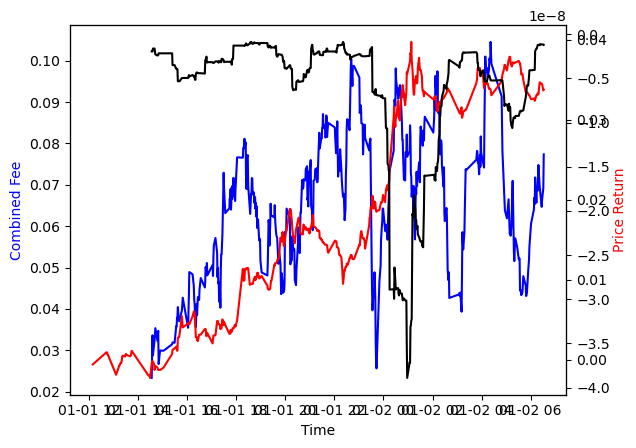

In [30]:
metrics['tcost_usd']

time_dex
2024-01-01 12:06:00      9.495196
2024-01-01 12:09:00     14.795757
2024-01-01 12:42:00     26.488070
2024-01-01 12:44:00     17.396276
2024-01-01 12:45:00     26.019482
                          ...    
2024-01-31 22:40:00    186.341550
2024-01-31 22:41:00     73.363984
2024-01-31 22:57:00    140.219617
2024-01-31 22:58:00     22.476679
2024-01-31 22:59:00     80.841936
Name: tcost_usd, Length: 11239, dtype: float64

In [29]:
metrics['dfee']

time_dex
2024-01-01 12:06:00     -15.955019
2024-01-01 12:09:00     -22.902877
2024-01-01 12:42:00    1242.036288
2024-01-01 12:44:00    -984.206108
2024-01-01 12:45:00    -423.644543
                          ...     
2024-01-31 22:40:00    -157.001146
2024-01-31 22:41:00    1408.961881
2024-01-31 22:57:00    2104.814488
2024-01-31 22:58:00    -170.792568
2024-01-31 22:59:00    -538.453412
Name: dfee, Length: 11239, dtype: float64

In [18]:
print(f"The total constant fees are: {round(metrics['cfee'].sum(), 2)}")
print(f"The total dynamic  fees are: {round(metrics['dfee'].sum(), 2)}")
print('')
print(f"The total pnl with c are: {round(metrics['cpnl'].sum(), 2)}")
print(f"The total pnl with d are: {round(metrics['dpnl'].sum(), 2)}")



The total constant fees are: 105502.55
The total dynamic  fees are: 17865975.58

The total pnl with c are: 105475.05
The total pnl with d are: 21573944.32


In [26]:
metrics['d%_toxic_flow_ma_7m'].sum()

-0.26702949134707754

In [27]:
metrics['c%_toxic_flow_ma_7m'].sum()

4753.730769298448